Import necessary libraries

In [1]:
import numpy as np
import array as arr
import sys 
import os
import time
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
import scipy.signal as sig
import scipy.linalg as LA
import mplcursors
from tqdm import tqdm
import seaborn as sns
import scipy
import pandas as pd
sns.set_theme()
# from mpldatacursor import datacursor
# %matplotlib inline 
# %matplotlib notebook
%matplotlib widget
import FluidID_configuration_1024 as cfg

Define FrameConfig Class

In [2]:
class FrameConfig: #
    def __init__(self):
        #  configs in configuration.py
        self.numTxAntennas = cfg.NUM_TX
        self.numRxAntennas = cfg.NUM_RX
        self.numLoopsPerFrame = cfg.LOOPS_PER_FRAME
        self.numADCSamples = cfg.ADC_SAMPLES
        self.numAngleBins = cfg.NUM_ANGLE_BINS

        self.numChirpsPerFrame = self.numTxAntennas * self.numLoopsPerFrame
        self.numRangeBins = self.numADCSamples
        self.numDopplerBins = self.numLoopsPerFrame
      
        # calculate size of one chirp in short.
        self.chirpSize = self.numRxAntennas * self.numADCSamples 
        # calculate size of one chirp loop in short. 3Tx has three chirps in one loop for TDM.
        self.chirpLoopSize = self.chirpSize * self.numTxAntennas
        # calculate size of one frame in short.
        self.frameSize = self.chirpLoopSize * self.numLoopsPerFrame

Reset Variables to clear memory

In [3]:
# %reset -f
# # To clear all variables from memory

## HELPER FUNCTIONS

Class to read raw Data from file

In [4]:
class RawDataReader:
    def __init__(self,path):
        self.path = path
        self.ADCBinFile=open(path,'rb')
       
    def getNextFrame(self,frameconfig):
        frame = np.frombuffer(self.ADCBinFile.read(frameconfig.
        frameSize*4),dtype=np.int16)
        return frame 

    def close(self):
        self.ADCBinFile.close()

Function to read binary input file

In [5]:
# Function to read data from bin file and store it in array
def ReadBinFile(filepath):
    bin_reader = RawDataReader(filepath)
    framecfg = FrameConfig()
    maxframes = int(np.floor(os.path.getsize(filepath)/(framecfg.frameSize*4)))

    print(maxframes)

    data = np.zeros((maxframes,cfg.NUM_TX,cfg.NUM_RX,cfg.LOOPS_PER_FRAME,cfg.ADC_SAMPLES),dtype=np.complex_)

    for frame in range(maxframes):
        reshape_data = frameReshape(bin2np_frame(bin_reader.getNextFrame(framecfg)),framecfg)
        data[frame,:,:,:,:] = reshape_data
    
    bin_reader.close()
    return data


Function to convert bin-file to numpy array

In [6]:
def bin2np_frame(bin_frame): #
    np_frame=np.zeros(shape=(len(bin_frame)//2), dtype=np.complex_)
    np_frame[0::2] = bin_frame[0::4]+1j*bin_frame[2::4]
    np_frame[1::2] = bin_frame[1::4]+1j*bin_frame[3::4]
    return np_frame

Function to reshape the read array into shape : [# of Tx, # of Rx, # of Chirps, # of Samples/Chirp]

In [7]:
def frameReshape(frame,frameConfig): #
    frameWithChirp = np.reshape(frame,(frameConfig.numLoopsPerFrame,frameConfig.numTxAntennas,frameConfig.numRxAntennas,-1))
    return frameWithChirp.transpose(1,2,0,3)

Function for background interference cancellation

In [8]:
def InterferenceCancellation(data, bk_data, framecfg = FrameConfig()):
    # Function description :
    # This function just subtracts the background interference from the data
    # @data: target data + background data
    # @bk_data: background data
    data_fft = np.fft.fft(data,n=framecfg.numRangeBins)
    data_mag = np.abs(data_fft)
    data_phase = np.angle(data_fft)

    bk_fft = np.fft.fft(bk_data,n=framecfg.numRangeBins)
    bk_mag = np.abs(bk_fft)
    bk_ang = np.angle(bk_fft)


    clean_data = np.fft.ifft(data_fft-bk_fft,n=framecfg.numADCSamples)
    return clean_data

Function to compute Doppler FFT 

In [9]:
def dopplerFFT(rangeResult,frameConfig): #
    windowedBins2D = rangeResult*np.reshape(np.hamming(frameConfig.numLoopsPerFrame),(1,1,-1,1))
    dopplerFFTResult=np.fft.fft(windowedBins2D,axis=3)
    dopplerFFTResult=np.fft.fftshift(dopplerFFTResult,axes=3)
    return dopplerFFTResult

Function to compute Range FFT

In [10]:
'''Function to calculate Range FFT to estimate time of flight'''
def rangeFFT(reshapedFrame,frameConfig): 
    windowedBins1D = reshapedFrame*np.hamming(frameConfig.numADCSamples)
    rangeFFTResult=np.fft.fft(windowedBins1D)
    return rangeFFTResult

Function to find peaks in the chirp range-fft per frame

In [11]:
def PeakFinder(filepath,backgroundfilepath, framecfg,frame_mean,  range_dist=[0, cfg.MAX_RANGE]):
  
     # Import file data frame by frame
    maxframes = int(np.floor(os.path.getsize(filepath)/(framecfg.frameSize*4)))
    # print(maxframes)

    ########################## LOAD BACKGROUND DATA ############################

    background_data = RearrangeChirps(ReadBinFile(backgroundfilepath))
    background_data = np.mean(background_data,axis=(1,4),keepdims=True) # Take mean of background static clutter data across frames and across chirps

    #############################################################################

    dist_ax = np.linspace(0,cfg.MAX_RANGE,num=cfg.ADC_SAMPLES, endpoint=False)

    # Narrow down peak finding zone from [x1 x2] (m) using prior knowledge of target location
    ind = (np.asarray(range_dist)/cfg.RANGE_RESOLUTION).astype(int)

    liquid = RearrangeChirps(ReadBinFile(filepath)) # Sepaate chirps as per different configurations i.e. 77 - 80 GHz

    #Subtract background clutter from water
    liquid_clean = liquid - background_data

    # Take fft of the result across ADC samples dimension
    liquid_clean_fft = np.abs(np.fft.fft(liquid_clean*np.hamming(framecfg.numADCSamples))/cfg.ADC_SAMPLES) # Normalize FFT by length of vector
    if len(liquid_clean_fft.shape) == 6:
        liquid_clean_fft = np.sum(liquid_clean_fft,axis=(2,4)) # Non-coherently integrate chirps across Tx antenna and Chirps
            # Normalization factor for above integration : /(liquid_clean_fft.shape[2]*liquid_clean_fft.shape[4])
        liquid_clean_fft = np.amax(liquid_clean_fft[:,:,:,ind[0]:ind[1]],axis=3) # Search maxima (i.e., peak across the combined representative chirp per frame)
        if frame_mean:
            liquid_clean_fft = np.mean(liquid_clean_fft,axis=1)
    else:
        liquid_clean_fft = np.sum(liquid_clean_fft,axis=(1,3)) # Non-coherently integrate chirps across Tx antenna and Chirps
        liquid_clean_fft = np.amax(liquid_clean_fft[:,:,ind[0]:ind[1]],axis=2) # Search maxima (i.e., peak across the combined representative chirp per frame)
        if frame_mean:
            liquid_clean_fft =  np.mean(liquid_clean_fft,axis=0) 

    return liquid_clean_fft   

Function to rearrange chirps when TDM MIMO configuration is used on the Tx side

In [12]:
# Function to rearrange the peak matrix so to have [x1...xm (for first chirp) y1...ym (for second chirp) z1...zm(for third chirp) and so on]
def RearrangeChirps(matrix):
    _num_chirp = 128
    total_chirps = matrix.shape[-2]

    factor = int(np.floor(total_chirps/_num_chirp))
    # print(factor)

    if factor == 1:
        # print('Factor : ',factor)
        return matrix
    
    freq_start = np.ones(matrix.shape)
    temp = []; temp_mtx = np.zeros((cfg.NUM_TX,cfg.NUM_RX,128,cfg.ADC_SAMPLES))
    
    for i in range(factor):
        temp_mtx = matrix[:, :, :, i:(total_chirps-factor+1)+i:factor, :]
        # print(temp_mtx.shape)
        temp.append(np.asarray(temp_mtx,dtype='object'))
    return np.asarray(temp,dtype='object')


Function to estimate frequency response through windowed envelope estimation

In [13]:
# Function to estimate fine-grained frequency response
def FineGrainFreqResponse(filepath,backgroundfilepath, framecfg, win, RI_component, reshape_flag, AoA_compensation, dist_range):
     '''
     @filepath: File path for liquid signal
     @backgroundfilepath: File path for background static clutter
     @framecfg: Frame Configuration
     @win: window samples [1,numADCSamples]
     @RI_component: "real" -- Real component ; "imag" -- Imag component ; "mag" -- Magnitude of samples
     @reshape_flag: 1 -- To concatenate all frames toghether 0 -- No concatenation
     @AoA_compensation: 1 -- Estimate AoA using MUSIC algorithm None -- No  AoA compensation
     @dist_range: Range of distance values for search of ToF
     '''
     # Calculate MAX FRAMES IN FILE 
     maxframes = int(np.floor(os.path.getsize(filepath)/(framecfg.frameSize*4)))
     # print(maxframes)

     ########################## LOAD BACKGROUND DATA ############################
     if backgroundfilepath is not None:
          background_data = RearrangeChirps(ReadBinFile(backgroundfilepath))
          background_data = np.mean(background_data,axis=(1,4),keepdims=True) # Take mean of background static clutter data across frames and across chirps

     #############################################################################

     liquid = RearrangeChirps(ReadBinFile(filepath)) # Read Beat Signal Samples from file and then reshape it according to chirp configuration

     #Subtract background clutter from liquid-data
     if backgroundfilepath is not None:
          liquid = liquid - background_data

     # Apply AoA compensation + Chirp summation
     if AoA_compensation is not None:
          liquid = AoA_Compensation(liquid,1,cfg.NUM_RX,dist_range)
          liquid = CombineChirp(liquid) # Combine chirps after AoA estimation
     
     # Separate Real/Imaginary/Magnitude
     if (RI_component) == "real":
          liquid = np.real(liquid)
     elif (RI_component) == "imag":
          liquid = np.imag(liquid)
     elif (RI_component) == "mag":
          liquid = np.abs(liquid)

     # Using the fact that chirp_period/Ts = Number of ADC samples
     N = cfg.ADC_SAMPLES
     Nprime = int(np.floor(N/win)) # Samples after windowing

     win_data_shape = list(liquid.shape[0:-1])
     win_data_shape.append(Nprime)

     
     win_data = np.zeros(win_data_shape)

     for i in range(Nprime):
          win_data[:,:,:,:,i] = np.amax(liquid[:,:,:,:,i*win:(i+1)*win],axis=4)
     
     # Check if AoA estimation is None or not
     if AoA_compensation is not None:
          rx = 1
     else:
          rx = cfg.NUM_RX

     # Concatenate all frames toghether
     if reshape_flag:
          reshape_response = np.zeros((cfg.NUM_TX,rx,cfg.LOOPS_PER_FRAME*(win_data.shape[0]),Nprime))
          for frame in range(win_data.shape[0]): # Parse over frames
               reshape_response[:,:,frame*cfg.LOOPS_PER_FRAME:(frame+1)*cfg.LOOPS_PER_FRAME,:] = win_data[frame,:,:,:,:]
          reshape_response = np.squeeze(reshape_response)
          reshape_response = np.reshape(reshape_response,(rx,-1)) # Return matrix of size (# of Rx, Nprime * # of Chirps)
          return (reshape_response, Nprime, liquid)


     return (win_data, Nprime, liquid)




Function for AoA using MUSIC

In [133]:
# MUSIC algorithm to estimate AoA per frame (estimation of azimuth angle)

def MUSIC(X,K,M,lamda,P):
    '''
     .. math::
        P_{\mathrm{MUSIC}}(\theta)
        = \frac{1}{\mathbf{a}^H(\theta) \mathbf{E}_\mathrm{n}
                   \mathbf{E}_\mathrm{n}^H \mathbf{a}(\theta)}
    '''
    # Defined variables
    d = lamda/2
    numAngles = 100 # Num of required angles

    # TO-DO: Check if the whole chirp frame is passed or if only one chirp data across all rx is passed
    x_shape = X.shape

    # TO-DO: Check if TDM MIMO setup is used --> if true rehsape it to NTx*NRx virtual antenna array shape
    if len(x_shape) == 4: # 4 means ( # of Tx, # of Rx, # of Chirps, # of samples/chirp)
        if x_shape[0] == 1: # Only 1 Tx is used
            X = np.squeeze(X)
        else:
            X = np.reshape(X,newshape=(x_shape[0]*x_shape[1],x_shape[2],x_shape[3]))                

    x_shape = X.shape # Find new array shape

    # Spatial Smoothing
    P = P # Subarray size
    L = M-P+1
    Rss = np.zeros(shape=(P,P),dtype='complex_')
    for chirp in range(1):
        for ant in range(L):
            Rcc = np.zeros(shape=(P,P),dtype='complex_')
            frag = X[ant:ant+P,chirp,:].squeeze()
            Rcc = frag@frag.T.conj()
            Rcc = Rcc/x_shape[-1] # Normalization by number of samples/chirp
            Rss += Rcc

    Rss = Rss/x_shape[1] # Normalization by # of chirps
    corr_matrix = Rss
    M = P; # Effective virtual antenna array size
    
    # Old Approach of calculating covariance matrix when spatial smoothing not used
    # corr_matrix = 0
    # if len(x_shape) == 3: # 3 means (# of Rx, # of Chirps, # of samples / chirp)
    #     for chirp in range(x_shape[1]):
    #         corr_matrix += X[:,chirp,:]@(X[:,chirp,:].conj().T)
    #     corr_matrix = corr_matrix * (1/x_shape[1])
    # else:
    #     corr_matrix = X@(X.conj().T)
    
    # # TODO: Add code for Modified MUSIC Algorithm [METHOD-2]
    # Jm = np.flip(np.identity(M), axis=0)
    # Ry = Jm @ corr_matrix.conj().T @ Jm

    # corr_matrix = (corr_matrix + Ry)/2
    # # ---------------------------------------- #
    
    corr_matrix = (corr_matrix + corr_matrix.conj().T) / 2

    D,EV = LA.eig(corr_matrix)
    index = np.argsort(np.abs(D)) # Sort eigenvalues in ascending order
    EN = EV[:,index]
    EN = EN[:, :M-K] # pick the eigenvetor corresponding to top M-K smallest eigenvalues
    # EN = EV[:,:-K]
    EN = np.transpose(np.conjugate(EN))

    # signal eignenvectors
    ES = EV[:,index]
    ES = ES[:, M-K:M]
    D = D[index]

    # # Defining new noise vectorspace
    # ES_nullspace = LA.null_space(ES @ np.diag(D[M-K:]) @ ES.conj().T)
    # orth_comp = LA.inv(ES_nullspace.conj().T @ ES_nullspace) @ ES_nullspace.conj().T @ EN.conj().T
    # EN = ES_nullspace @ orth_comp
    # EN = EN.conj().T
    
    Angles = np.linspace(-90,90,numAngles)
    # Angles = Angles * (np.pi/180.0)
    Angles = np.linspace(-np.pi/2,np.pi/2,numAngles)
    SP = np.zeros(Angles.size)
    for i in range(numAngles):
        a = np.exp(1j*np.pi*np.arange(0,M,1)*np.sin(Angles[i])).reshape(-1,1)
        # a = a * np.exp(1j* 2*np.pi*cfg.START_FREQ*1e9*np.arange(0,M,1) / (cfg.SAMPLE_RATE*1e3*M))
        # a = np.cos(2*np.pi*np.arange(0,M,1)*np.cos(Angles[i]*np.pi/180)/lamda).reshape(-1,1)
        p_spectrum = EN@a
        
        SP[i] = 1/(LA.norm(p_spectrum,2))**2

    return (SP, D, EN, ES)

Function for AoA compensation after angle estimation using MUSIC 

In [15]:
'''Calculate AoA using MUSIC & compensate it across the receiver/s'''
def AoA_Compensation(data, K, M, dist_range):
    # 1) Define time vector
    t = np.linspace(0,cfg.RAMP_END_TIME*1e-6, cfg.ADC_SAMPLES)

    # 2) Estimate AoA using MUSIC
    angles = np.linspace(-90,90,180)

    ToF_mtx = np.zeros(shape = (data.shape[0], cfg.NUM_RX, FrameConfig().numChirpsPerFrame))
    ToF = np.linspace(0, cfg.SAMPLE_RATE*1e3, cfg.NUM_RANGE_BINS) * (1 / (cfg.FREQ_SLOPE*1e12))
    
    est_ang = []
    for frm in range(data.shape[0]):
        frame_data = np.squeeze(data[frm,:,:,:,:])
        Nsources = K
        lamda = 3e8/(cfg.START_FREQ*1e9)

        P_Spectrum = MUSIC(frame_data,Nsources,M,lamda)

        # 3) find peak in the AoA power spectrum
        p_index = np.where(P_Spectrum==np.amax(P_Spectrum))

        # 4) Target angle
        p_angle = np.abs(angles[p_index])

        # 5) Store the angle 
        est_ang.append(p_angle)

        # 6) Estimate ToF using Range-FFT
        rngFFT = rangeFFT(frame_data,FrameConfig()) # Return size: (Nrx, # Chirps, # Samples/chirp)
        ind0 = int(dist_range[0]/cfg.RANGE_RESOLUTION) # Start search distance
        ind1 = int(dist_range[1]/cfg.RANGE_RESOLUTION) # End search distance
        ToF_estimate = ind0 + np.argmax(rngFFT[:,:, ind0:ind1],axis=2)
        ToF_mtx[frm,:,:] = ToF[ToF_estimate]
    
    # 6) Estimate AoA using the mean AoA of all frames
    est_ang = np.array(est_ang)
    est_ang = np.mean(est_ang) * np.pi/180.0 # Conversion to rad

    data_cmp = data # Data with compensated AoA
    # 7) Compensate the AoA 
    for frm in range(data.shape[0]):
        for tx in range(data.shape[1]):
            for rx in range(data.shape[2]):
                for chirp in range(data.shape[3]):
                    td = ToF_mtx[frm,rx,chirp]
                    sp_delay = (rx * lamda/2 * np.sin(est_ang))/3e8
                    td = td - sp_delay
                    data_cmp[frm, tx, rx, chirp, :] = np.dot(data_cmp[frm, tx, rx, chirp, :], np.exp(-1j*(2*np.pi*cfg.START_FREQ*1e9*td - np.pi*(td**2-2*t*td)*cfg.FREQ_SLOPE*1e12)))

    return data_cmp
        


Function to combine chirp  after AoA compensation has been done

In [16]:
'''Function to combine chirp across all receivers after AoA compensating'''
def CombineChirp(framedata):
    if len(framedata.shape) == 5: # If all frames are passed 
        return np.mean(framedata, axis=2, keepdims=True)
    elif len(framedata.shape) == 4:
        return np.mean(framedata, axis=1, keepdims=True)

## Experimental Code Testing before integrating in the main pipeline

[['exp_ang_-20_trace1.bin', 'exp_ang_-20_trace0.bin'], ['exp_ang_+20_trace0.bin', 'exp_ang_+20_trace2.bin', 'exp_ang_+20_trace1.bin'], ['exp_ang_50_trace1.bin', 'exp_ang_50_trace0.bin', 'exp_ang_50_trace2.bin'], ['exp_ang_-50_trace2.bin', 'exp_ang_-50_trace0.bin', 'exp_ang_-50_trace1.bin'], ['exp_ang_0_trace1.bin', 'exp_ang_0_trace0.bin', 'exp_ang_0_trace2.bin'], ['exp_nothing.bin']]
exp_ang_0_trace0.bin
120
120
Shape of Liquid data array (120, 2, 4, 128, 1024)


100%|██████████| 120/120 [00:00<00:00, 263.52it/s]


(100, 120)


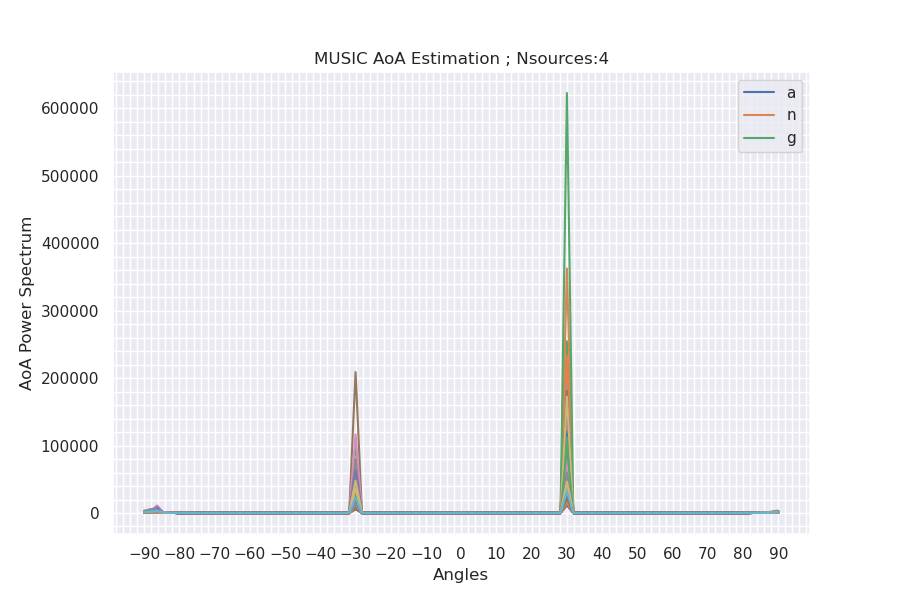

In [134]:
''' ** EXPERIMENTAL :: CELLS FOR TESTING STUFF BEFORE MERGING IN THE MAIN PIPELINE ** '''

# TO-DO : AoA for previous captured data (e.g. for water-data)

# 1) Code chunk for importing file names and sorting them based on different liquids
filepath = "/home/muaz/Documents/Muaz_Git_Repo/New_AoA_data/"
fpath = os.listdir(filepath)

framecfg = FrameConfig()

# extension = ".bin"
# liquids = ["no-liquid","water","vinegar","oil","baking-soda","saline"]

liquids = ["exp_ang_-20","exp_ang_+20","exp_ang_50","exp_ang_-50","exp_ang_0","exp_nothing"]
# liquids = [s + extension for s in liquids]

liq_files = []

for liq in liquids:
    temp_ind = []
    for files in fpath:
        if liq in files:
            temp_ind.append(files)
    liq_files.append(temp_ind)

# Print liq_files names
print(liq_files)

# 2) Import specific data filepaths (e.g. water-1.bin data)
data = liq_files[liquids.index("exp_ang_0")][1]
fname = data # File name
print(data)

bk_data = liq_files[liquids.index("exp_nothing")][0]
# 3) Read background data file
bk_data = RearrangeChirps(ReadBinFile(filepath+bk_data))
bk_data = np.mean(bk_data,axis=(3),keepdims=True) # Dimensions (3) represent averaging chirp data across all chirps
# print("Shape of Mean Bakcground data ", bk_data.shape)


# 4) Read liquid data
orig_data = ReadBinFile(filepath + data)
clean_data = InterferenceCancellation(orig_data,bk_data) # Background Static Clutter

data = clean_data


print("Shape of Liquid data array", data.shape)

NumofAngles = 100 # Number of angles between [-x y]

# 5) Loop through all the frames to estimate the AoA
aoa_spectrum = np.zeros(shape = (NumofAngles, data.shape[0]))

Nsources = np.linspace(1,7,7, dtype='int') # Possible # of sources

P = 6; # Number of subarray elements

for frm in tqdm(range(data.shape[0])):
    frame_data = data[frm,:,:,:,:] # Pass frame with shape (# of Tx, # of Rx, # of chirps, # of samples/chirp) to MUSIC

    # 6) Calculate AoA for each frame now
    Ns =4 # Number of sources
    (P_spectrum, D, EN, ES) = MUSIC(frame_data,Ns,cfg.NUM_TX*cfg.NUM_RX,3e8/(cfg.START_FREQ*1e9),P)
    EN = np.conj(EN.T)
    # 7) Save the spectrum in the array
    aoa_spectrum[:,frm] = P_spectrum

print(aoa_spectrum.shape)

# 8) Plot Aoa Spectrum for all the frames
Angles = np.linspace(-90,90,NumofAngles)

plt.figure("AoA-Spectrum", figsize=(9,6),clear=True)
# ax = fig_aoa.add_subplot(1,1,1)
plt.plot(Angles, aoa_spectrum)
plt.xlabel("Angles")
plt.ylabel("AoA Power Spectrum")
plt.title("MUSIC AoA Estimation ; Nsources:"+str(Ns))
mplcursors.cursor(plt.gca(), multiple=True)
plt.minorticks_on()
plt.grid(True, which="both")
plt.legend(fname.split("_")[1])
plt.gca().set_xticks(np.arange(-90, 100, 10))
plt.show()

# # 9) Compensated IF chirp samples
# data_cmp = AoA_Compensation(data,Nsources,cfg.NUM_RX,[0.35,0.70])
# print(data_cmp.shape)

# # 10) Combine Chirps after AoA compensating
# data_cmp = CombineChirp(data_cmp)
# print(data_cmp.shape)



In [105]:
# Print Eigenvalues of covariance matrix
display(pd.DataFrame(np.abs(D),columns=['Rxx eigenvalues']))

,Rxx eigenvalues
0,3.974247
1,4.402756
2,262.009717
3,711.111267
4,1144.548868
5,4790.283669


In [27]:
# # plt.figure("Range-FFT",figsize=(9,6))
# for frm in range(data.shape[0]):
#     frame_data = np.squeeze(data[frm,:,:,:,:])
#     range_fft = rangeFFT(frame_data,FrameConfig())
#     f_axis = np.linspace(0,cfg.SAMPLE_RATE*1e3,cfg.ADC_SAMPLES)
#     # plt.plot(np.abs(range_fft[:,0,:]))
# # plt.show()
D = D[np.argsort(np.abs(D))]

noisespace = EN @ np.diag(D[:(cfg.NUM_TX*cfg.NUM_RX)-Ns]) @ np.conj(EN.T)
sigspace = ES @ np.diag(D[(cfg.NUM_TX*cfg.NUM_RX)-Ns:]) @ np.conj(ES.T)

# print(noisespace.shape)
# print(sigspace.shape)

dotprod = pd.DataFrame(np.abs(np.dot(np.conj(noisespace.T),sigspace)))
display(dotprod)

# display(pd.DataFrame(D,columns=['EigenValues of Cov Mtx']))

nullspace_of_signalspace = LA.null_space(sigspace)
print(nullspace_of_signalspace.shape)

orth_comp = LA.inv(np.conj(nullspace_of_signalspace.T) @ nullspace_of_signalspace) @ nullspace_of_signalspace.conj().T @ EN

# print(orth_comp.shape)
# display(pd.DataFrame(orth_comp))

EN_new = nullspace_of_signalspace @ orth_comp
noisespace = nullspace_of_signalspace @ orth_comp @ nullspace_of_signalspace.conj().T

dotprod = pd.DataFrame(np.abs(np.dot(np.conj(EN_new.T),ES)))
display(dotprod)

,0,1,2,3,4,5,6,7
0,0.003470,0.001968,0.001221,0.001734,0.000665,0.002697,0.001696,0.002351
1,0.001202,0.001185,0.000821,0.000386,0.000854,0.001425,0.001016,0.000819
2,0.002946,0.001234,0.002686,0.002940,0.002479,0.000743,0.002205,0.003918
3,0.007884,0.004152,0.002037,0.006035,0.004974,0.006108,0.001079,0.005992
4,0.006375,0.003559,0.001711,0.006925,0.006367,0.003662,0.000580,0.004074
5,0.002046,0.000440,0.002319,0.002090,0.002280,0.000345,0.002323,0.002566
6,0.004422,0.002697,0.001953,0.004410,0.004415,0.003418,0.002198,0.003945
7,0.003959,0.004158,0.000458,0.003217,0.003039,0.003954,0.001054,0.003170


(8, 6)


,0,1
0,1.444335e-16,7.757919e-18
1,1.090015e-16,5.810822e-17
2,3.198672e-17,1.626607e-16
3,8.139869e-18,4.195736e-17
4,6.938894e-17,6.059129e-17
5,3.469447e-17,1.666330e-16


In [166]:
# Code to check range fft

bk_fft = rangeFFT(bk_data,FrameConfig())


# frame_data = data[0,1,:,105,:].squeeze()
# range_fft = np.absolute(rangeFFT(data,FrameConfig())) - np.absolute(rangeFFT(bk_data,FrameConfig()))
range_fft = rangeFFT(orig_data,FrameConfig())
print(range_fft.shape)
f_axis = np.linspace(0,cfg.SAMPLE_RATE*1e3,cfg.ADC_SAMPLES)


# sub_data = np.diff(range_fft,n=1,axis=4,prepend=0) # 
sub_data = rangeFFT(clean_data,FrameConfig())

bk_fft = bk_fft[0,1,:,:,:].squeeze()
range_fft = range_fft[0,1,:,105,:].squeeze()
sub_data = sub_data[0,1,:,105,:].squeeze()

# sub_data = np.abs(range_fft) - np.abs(np.pad(bk_fft[:,7:],((0,0),(7,0)),'constant',constant_values=0))

# Nshift_possible = cfg.ADC_SAMPLES
# Energy = []
# for shift in range(Nshift_possible):
#     sub_data = np.abs(range_fft) - np.abs(np.pad(bk_fft[:,shift:],((0,0),(shift,0)),'constant',constant_values=0))
#     Energy.append(LA.norm(sub_data,2))
#     if (shift>0) and (0<=Energy[shift-1]-Energy[shift]<=1e4):
#         break

    

(120, 2, 4, 128, 1024)


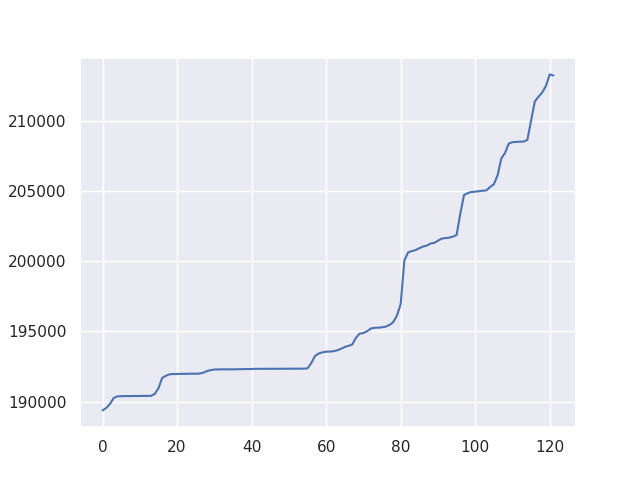

In [165]:
plt.figure("figure y",clear=True)
plt.plot(Energy)
plt.show()

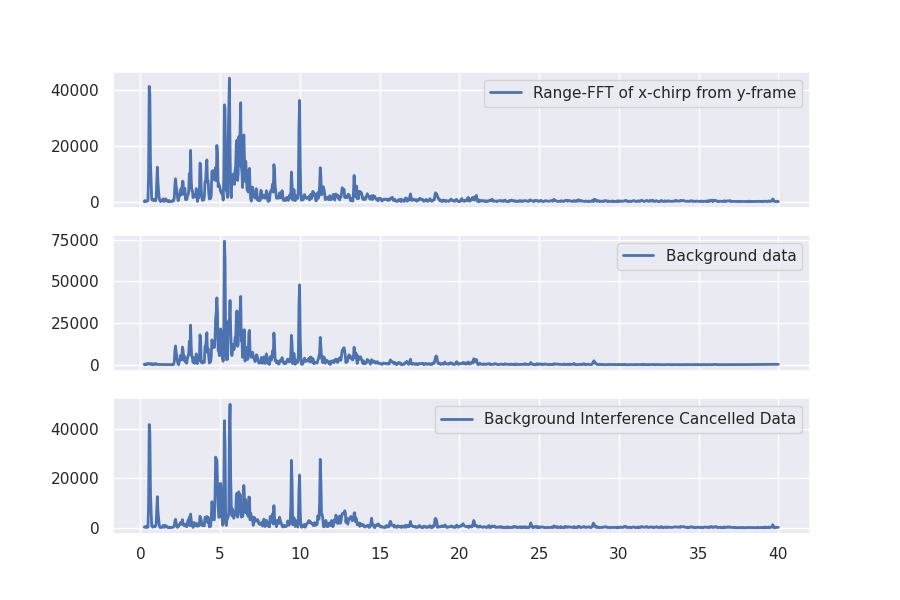

In [170]:
freq2time = cfg.FREQ_SLOPE * 1e12
freq2range_factor = 3e8/(2*cfg.FREQ_SLOPE*1e12)

range_axis = f_axis * freq2range_factor
ToF_axis = f_axis/freq2time

# plt.plot("Range-FFT", figsize=(9,6),clear=True)
fig, axes = plt.subplots(3,1,sharex=True,figsize=(9,6),)
# plt.sca(axs[0])
axes[0].plot(range_axis[(range_axis > 0.20) & (range_axis < 40)], np.abs(range_fft.T)[(range_axis > 0.20) & (range_axis < 40),0],linewidth=2,label='Range-FFT of x-chirp from y-frame')
axes[1].plot(range_axis[(range_axis > 0.20) & (range_axis < 40)], np.abs(bk_fft.T)[(range_axis > 0.20) & (range_axis < 40),0],linewidth=2,label='Background data')
axes[2].plot(range_axis[(range_axis > 0.20) & (range_axis < 40)], np.abs(sub_data.T)[(range_axis > 0.20) & (range_axis < 40),0],linewidth=2,label='Background Interference Cancelled Data')
# plt.xlabel('Distance (m)')
# plt.ylabel('Amplitude')
mplcursors.cursor(axes, multiple=True)
# mplcursors.cursor(plt.gca(), multiple=True)
# plt.gca().legend()
# plt.minorticks_on()
# plt.grid(True, which = "both")
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.show()

In [54]:
# Angle-FFT approach
dat = clean_data
fcfg = FrameConfig()

Rfft = rangeFFT(dat,fcfg)
peak_ind = np.argmax(np.abs(Rfft),axis=4)

Dfft = dopplerFFT(Rfft,fcfg)

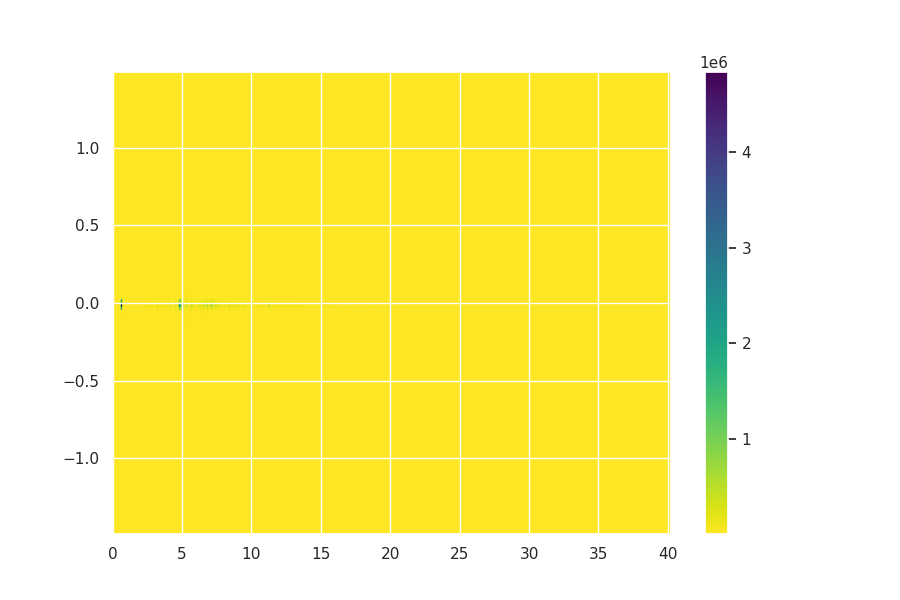

In [56]:
test_frame = Dfft[0,1,:,:,:]
plt.figure('new figure',figsize=(9,6),clear=True)
plt.imshow(np.abs(test_frame[0,:,:].squeeze()),cmap=plt.cm.viridis_r,interpolation='none',aspect='auto',extent=[(f_axis*freq2range_factor)[0],(f_axis*freq2range_factor)[-1],-cfg.MAX_DOPPLER/2,cfg.MAX_DOPPLER/2])
plt.colorbar()
mplcursors.cursor(plt.gca(),multiple=True)
plt.show()

## Main System Pipleline

Liquid file under analysis : water-0.bin
Liquid file under analysis : water-3.bin
Liquid file under analysis : water-2.bin
Liquid file under analysis : water-1.bin
Liquid file under analysis : vinegar-1.bin
Liquid file under analysis : vinegar-0.bin
Liquid file under analysis : vinegar-3.bin
Liquid file under analysis : vinegar-2.bin
Liquid file under analysis : oil-3.bin
Liquid file under analysis : oil-1.bin
Liquid file under analysis : oil-0.bin
Liquid file under analysis : oil-2.bin
Liquid file under analysis : baking-soda-0.bin
Liquid file under analysis : baking-soda-1.bin
Liquid file under analysis : baking-soda-2.bin
Liquid file under analysis : baking-soda-3.bin
Liquid file under analysis : saline-3.bin
Liquid file under analysis : saline-0.bin
Liquid file under analysis : saline-2.bin
Liquid file under analysis : saline-1.bin


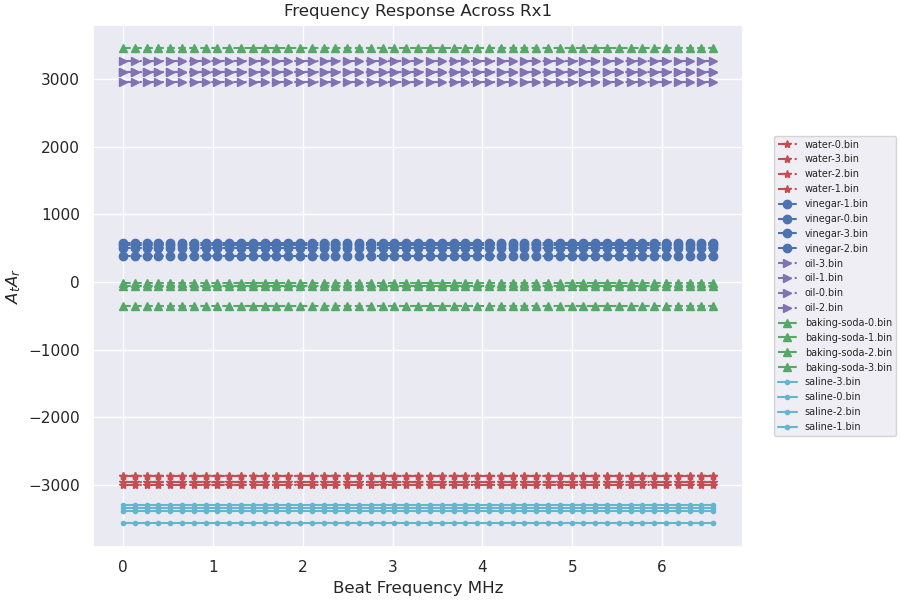

In [52]:
# TODO: Add interfernece cancellation routine in the functions
if __name__=="__main__":
    filepath = "/home/muaz/Documents/Muaz_Git_Repo/LabExp_6April_1024samplesperchirp/"
    fpath = os.listdir(filepath)

    framecfg = FrameConfig()
    
    # extension = ".bin"
    liquids = ["no-liquid","water","vinegar","oil","baking-soda","saline"]
    # liquids = [s + extension for s in liquids]

    liq_files = []
   
    for liq in liquids:
        temp_ind = []
        for files in fpath:
            if liq in files:
                temp_ind.append(files)
        liq_files.append(temp_ind)

    # Window Size
    win = [20]

    # Plot color and markers for different liquids
    plot_clr = ["r*-." , "bo--","m>-.","g^--","c.-","yd-"] #,"k<-"]

    fig, axes = plt.subplots(1,1,figsize=(9,6),constrained_layout=True, sharex = True)

    for (liquid_files,fmt) in zip(liq_files[1:],plot_clr) :
        for file in liquid_files :
            print("Liquid file under analysis : " + file)
            for window in win:
                ################################# Signal Extraction #####################################3
                # file_peak = PeakFinder(filepath+file,filepath+liq_files[0][0],framecfg,True,[0.30,0.65])
                # print(file_peak.shape)
# Function template: FineGrainFreqResponse(filepath,backgroundfilepath, framecfg, win, RI_component, reshape_flag, AoA_compensation, dist_range)
                [file_peak ,Nprime, liq_data] = FineGrainFreqResponse(filepath+file,filepath+liq_files[0][0],framecfg,window,"real",1,True,[0.35,0.70])                # print(file_peak.shape)
                del_f = (cfg.SAMPLE_RATE*1e3)/Nprime
                x_axis = np.linspace(0,cfg.SAMPLE_RATE*1e3-del_f,num=Nprime)/1e6
                
                axes.plot(x_axis,file_peak[0,0:1*Nprime],fmt) #plot(x_axis,file_peak[0,0:1*Nprime],fmt)
                axes.set_xlabel("Beat Frequency MHz")
                axes.set_ylabel("$A_{t} A_{r}$")
                axes.set_title("Frequency Response Across Rx1")

                # axes[0,1].plot(x_axis,file_peak[1,0:1*Nprime],fmt)
                # axes[0,1].set_xlabel("Beat Frequency MHz")
                # axes[0,1].set_ylabel("$A_{t} A_{r}$")
                # axes[0,1].set_title("Frequency Response Across Rx2")

                # axes[1,0].plot(x_axis,file_peak[2,0:1*Nprime],fmt)
                # axes[1,0].set_xlabel("Beat Frequency MHz")
                # axes[1,0].set_ylabel("$A_{t} A_{r}$")
                # axes[1,0].set_title("Frequency Response Across Rx3")

                # axes[1,1].plot(x_axis,file_peak[3,0:1*Nprime],fmt)
                # axes[1,1].set_xlabel("Beat Frequency MHz")
                # axes[1,1].set_ylabel("$A_{t} A_{r}$")
                # axes[1,1].set_title("Frequency Response Across Rx4")

    legend_lst = [x for l in liq_files[1:] for x in l]
    # legend_lst = win
    axes.legend(legend_lst,loc='center left',bbox_to_anchor=(1.04,0.5),prop={'size': 7}) #[item for item in liq_files[1:]]
    # axes[0,1].legend(legend_lst,loc='center left',bbox_to_anchor=(1.04,0.5),prop={'size': 7})
    # axes[1,0].legend(legend_lst,loc='center left',bbox_to_anchor=(1.04,0.5),prop={'size': 7})
    # axes[1,1].legend(legend_lst,loc='center left',bbox_to_anchor=(1.04,0.5),prop={'size': 7})
    mplcursors.cursor(multiple=True)
    plt.show()



In [26]:
# Observe Imapact of interference cancellation on liquid data

no_liquid_data = RearrangeChirps(ReadBinFile(filepath+liq_files[0][0]))

liquid_data = RearrangeChirps(ReadBinFile(filepath+liq_files[1][0]))

liquid_data_wo_interference = liquid_data - no_liquid_data


T = np.arange(0,(cfg.ADC_SAMPLES)*(1/(cfg.SAMPLE_RATE*1e3)),1/(cfg.SAMPLE_RATE*1e3))

plt.figure(num='Preliminary - Analysis',figsize=(12,6))
plt.plot(T, np.real(np.transpose(np.squeeze(no_liquid_data[0,:,0,0,:]))))

plt.plot(T, np.real(np.transpose(np.squeeze(liquid_data[0,:,0,0,:]))))

plt.plot(T, np.real(np.transpose(np.squeeze(liquid_data_wo_interference[0,:,0,0,:]))))


plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.legend(["Background","Liquid","Liquid - Background"])

plt.show()

In [35]:
print(liq_files[1])
liq_data = RearrangeChirps(ReadBinFile(filepath+liq_files[-1][-1])) 
liq_data = liq_data - np.mean(RearrangeChirps(ReadBinFile(filepath+liq_files[0][0])),axis = (1,4), keepdims=True)

print(liq_data.shape)

one_chirp = liq_data[0,:,0,0,:][0]
one_chirp_real = np.real(one_chirp)

max_pooled_output = np.zeros(one_chirp_real.shape)
ind = np.array([np.where(one_chirp_real == x) for x in file_peak[0,0:Nprime]])
max_pooled_output[ind] = file_peak[0, 0:1*Nprime:1]


# Plotting original chirp 
plt.figure(figsize=(10,6))
plt.plot(one_chirp_real,"b*-")
plt.plot(np.arange(0,256,1),max_pooled_output,"ro-.")
plt.title("Time domain chirp samples for Rx1")
plt.show()

['water-0.bin', 'water-3.bin', 'water-2.bin', 'water-1.bin']
(300, 1, 4, 128, 1024)


/tmp/ipykernel_168422/3712204869.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ind = np.array([np.where(one_chirp_real == x) for x in file_peak[0,0:Nprime]])


IndexError: arrays used as indices must be of integer (or boolean) type

In [36]:
filepath_1024 = "/home/muaz/Documents/Muaz_Git_Repo/LabExp_6April_1024samplesperchirp/"
fpath = os.listdir(filepath_1024)

framecfg = FrameConfig()

# extension = ".bin"
liquids = ["no-liquid", "water","vinegar","oil","baking-soda","saline"]
# liquids = [s + extension for s in liquids]

liq_files = []

for liq in liquids:
    temp_ind = []
    for files in fpath:
        if liq in files:
            temp_ind.append(files)
    liq_files.append(temp_ind)

print(liq_files)

data = RearrangeChirps(ReadBinFile(filepath_1024+liq_files[1][0])) - np.mean(RearrangeChirps(ReadBinFile(filepath_1024+liq_files[0][0])),axis = (1,4), keepdims=True)
print(data.shape)


[['no-liquid-0.bin', 'no-liquid-1.bin', 'no-liquid.bin', 'no-liquid-2.bin'], ['water-0.bin', 'water-3.bin', 'water-2.bin', 'water-1.bin'], ['vinegar-1.bin', 'vinegar-0.bin', 'vinegar-3.bin', 'vinegar-2.bin'], ['oil-3.bin', 'oil-1.bin', 'oil-0.bin', 'oil-2.bin'], ['baking-soda-0.bin', 'baking-soda-1.bin', 'baking-soda-2.bin', 'baking-soda-3.bin'], ['saline-3.bin', 'saline-0.bin', 'saline-2.bin', 'saline-1.bin']]
(300, 1, 4, 128, 1024)


#### Plot one chirp time domain samples from frame 0

### Reading data with 1024 samples/chirp rather than 256 samples/chirp

/tmp/ipykernel_168422/2824306446.py:10: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig, axes = plt.subplots(2,2,'all',figsize=(12,6))


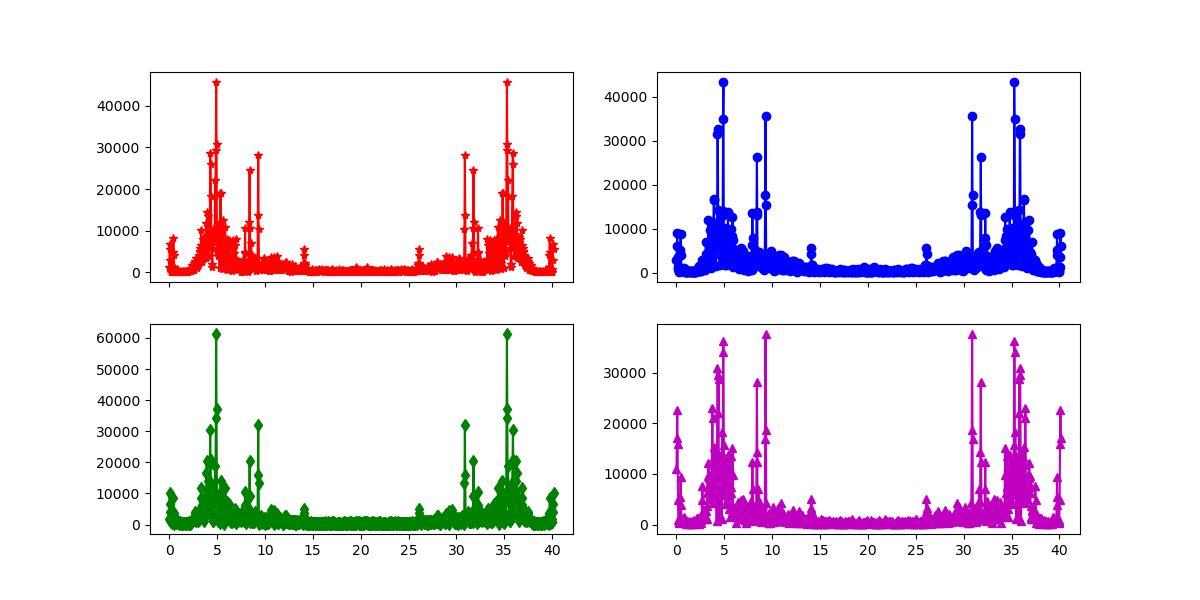

In [47]:
chirp_1024 = data[0,0,:,0,:]
chirp_1024 = np.real(chirp_1024)

fft_chirp = np.fft.fft(chirp_1024*np.hamming(cfg.ADC_SAMPLES),axis=-1)
chirp_1024 = np.abs(fft_chirp)

# x_axis = np.linspace(0,cfg.SAMPLE_RATE*1e3,cfg.ADC_SAMPLES)/1e6
x_axis = np.linspace(0,cfg.MAX_RANGE-cfg.RANGE_RESOLUTION,cfg.ADC_SAMPLES)

fig, axes = plt.subplots(2,2,'all',figsize=(12,6))

axes[0,0].plot(x_axis,chirp_1024[0,:],"r*-")

axes[0,1].plot(x_axis,chirp_1024[1,:],"bo-")

axes[1,0].plot(x_axis,chirp_1024[2,:],"gd-")

axes[1,1].plot(x_axis,chirp_1024[3,:],"m^-")

# datacursor(display='multiple', draggable=True)

plt.show()

## Playground Section to write code for new functionalities + Simulation

#### MUSIC Algorithm Python Code [Version-1]

In [59]:
def MUSIC_test(X,K,M,lamda):
    d = lamda/2
    numAngles = 180

    corr_matrix = X@(X.conj().T)
    corr_matrix = (corr_matrix + corr_matrix.conj().T) / 2

    D,EV = LA.eig(corr_matrix)
    index = np.argsort(D)
    EN = EV[:,index]
    EN = EN[:, :M-K]
    EN = np.transpose(np.conjugate(EN))

    Angles = np.linspace(-90,90,numAngles)
    SP = np.zeros(Angles.size)
    for i in range(numAngles):
        a = np.exp(-1j*np.pi*np.arange(0,M,1)*np.sin(Angles[i]*np.pi/180)).reshape(-1,1)
        p_spectrum = EN@a
        
        SP[i] = 1/np.linalg.norm(p_spectrum)

    return SP

#### AoA Estimation using MUSIC

In [71]:
# Generate FMCW chirp parameters
fc = 77e9 # Start Frequency
c = 3e8 # Speed of Light
Ns = 1024 # ADC samples

Tramp = 156.56e-6 # Ramp up time
Tidle = 7e-6 # Chirp Idle Time
Tchirp = Tramp+Tidle # sec
Slope = 25.009e12 # Hz/s
Fs = 6700e3 # samples/sec


# Rmax = 200
# Tsweep = 5.5
# Tchirp = Tsweep * (2*Rmax/c)
# B = 4e9


# Slope = B/Tchirp
# Fs = Ns/Tchirp # samples/sec
Ts = 1/Fs

B = ((Slope*Ns)/Fs) # Valid Sweep Bandwidth

# -------------------------------------------------------------------------- #
r_gt = np.array([1, 3, 10]) # Object location in meters
angle_gt = np.array([30, 10, -45]) # Ground Truth Angle in Degrees
angle_gt_rad = angle_gt * np.pi/180.0 # Angle in radians
# angle_gt_rad = np.array([0, np.pi/10, -np.pi/4]) # Angle in radians
alpha = np.array([1/2, 1/4, 1/8]) # Receiving gains

Nrx = 8 # Number of receiving antennas
Ntx = 1 # Number of transmitting antennas

lamda = c/fc 
sep = lamda/2 # Half-wavelength separation

Tsampling = Ns/Fs

In [72]:
# Generate Transmitted signal

t = np.linspace(0,Tchirp,Ns)

def FMCW_Tx(t):
    return np.exp(-1j*2*np.pi*(fc*t + 0.5*(B/Tchirp)*(t**2)))

def lpf(data, filter,cutoff,fs,order=5):
    nyq = fs * 0.5
    normal_cutoff = cutoff / nyq
    b, a = sig.butter(order, normal_cutoff, btype=filter, analog=False)
    y = sig.lfilter(b, a, data)
    return y

Tx = FMCW_Tx(t)
t_d = r_gt/c

Rx = np.zeros((Nrx,Ns),dtype='complex_')
for j in range(Nrx):
    for i in range(len(t_d)):
        time_delay = t_d[i] - j*sep*np.sin(angle_gt_rad[i])/c
        Rx_temp =  alpha[i] * FMCW_Tx(t - time_delay)
        Rx[j,:] += Rx_temp

mix = np.multiply(Tx,Rx)
mix_filt = lpf(mix, 'low', 5e6/Fs, Fs, order=1)

# print(mix_filt.shape)



In [73]:
Mix_FFT = np.fft.fft(mix)
freq_axis = np.linspace(0, Fs, Ns)
freq2range_factor = c/(2*Slope)

# plt.figure(figsize=(9,9))
# plt.plot(freq_axis*freq2range_factor, np.abs(np.transpose(Mix_FFT)))
# plt.xlabel("Range (m)")
# plt.ylabel("Magnitude")
# plt.title("FFT Magnitude")
# plt.show()

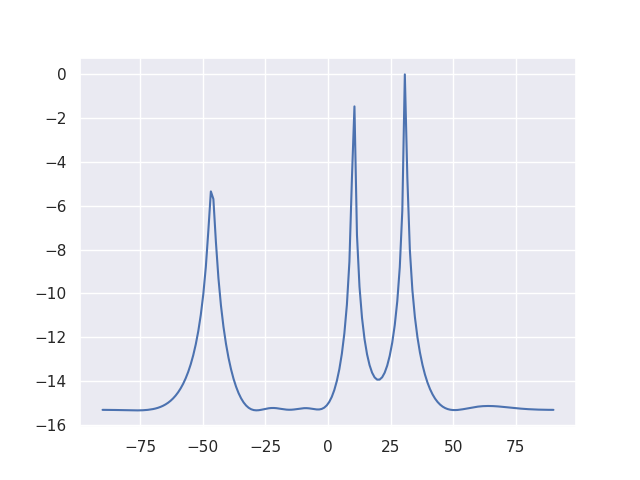

In [88]:
# AoA estimation using MUSIC
SP,_,_ = MUSIC(mix_filt,3,Nrx,lamda)

Angles = np.linspace(-np.pi/2,np.pi/2,len(SP))

plt.figure(10, figsize=(9,5), clear=True)
SP = np.abs(SP)
SPmax = np.max(SP)
SP = 10 * np.log10(SP / SPmax)
x = Angles * 180/np.pi
plt.plot(x, SP)
mplcursors.cursor(plt.gca(),multiple=True)
plt.show()
plt.minorticks_on()
plt.grid(True, which="both")


In [87]:
'''Generate 2Tx-4Rx TDM MIMO radar setting'''
Ntx = 2
t = np.linspace(0,Ntx*Tramp,Ntx*Ns)
tdm_tx = FMCW_Tx(t)
tdm_reshape = np.zeros(shape = (Ntx, Ns),dtype='complex_')
for i in range(Ntx):
    print(i)
    tdm_reshape[i,:] = tdm_tx[i*Ns:(i+1)*Ns]

for tx in range(Ntx):
    

0
1
[[ 1.        +0.j         -0.79906753+0.60124128j  0.01337784+0.99991051j
  ... -0.1245806 +0.99220949j -0.7379235 +0.67488437j
   0.94610967-0.32384639j]
 [ 0.97743418-0.21124023j -0.92492333+0.3801537j  -0.65156653+0.75859149j
  ... -0.15080857+0.98856298j -0.9697987 +0.2439067j
   0.80651757+0.59121013j]]
